In [9]:
%load_ext autoreload
%autoreload 2

from deltas.pipeline import data, classifier, evaluation
from deltas.model import base, downsample
import deltas.plotting.plots as plots
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# np.random.seed(10)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:

N1 = 10000
N2 = 10
m = 1
v = 1
runs = [6, 10, 30, 70, 100, 150, 200, 300, 500, 1000, 2000, 5000]
results = {}
for run in tqdm(runs):
    N2 = run
    dfs = []
    while len(dfs) < 2:
        data_clf = data.get_data(
            m1=[-m, -m],
            m2=[m, m],
            cov1=[[v, 0], [0, v]],
            cov2=[[v, 0], [0, v]],
            N1=N1,
            N2=N2,
            scale=False,
            test_nums=[10000, 10000],
        )

        model = 'SVM-linear'
        model = 'SVM-rbf'
        model = 'MLP'
        model = 'MLP-Gaussian'
        model = 'Linear'

        classifiers_dict = classifier.get_classifier(
            data_clf=data_clf,
            model=model,
            _plot=False)
        data_clf['clf'] = classifiers_dict['Baseline']
        X = data_clf['data']['X']
        y = data_clf['data']['y']
        clf = data_clf['clf']
        # deltas_model = downsample.downsample_deltas(
        #     clf).fit(X, y, _print=True, _plot=True, max_trials=10000)
        # deltas_model = base.base_deltas(
        #     clf).fit(X, y, grid_search=True, _print=True, _plot=True)
        deltas_model = downsample.downsample_deltas(clf).fit(X, y,
                                                            alpha=1,
                                                            _print=False,
                                                            _plot=False,
                                                            method='supports-prop-update_mean',
                                                            max_trials=10000,
                                                            parallel=True)

        if deltas_model.is_fit == True:
            classifiers_dict['Our Method'] = deltas_model
            scores_df = evaluation.eval_test(classifiers_dict,
                                            data_clf['data_test'], _print=False, _plot=False)
            dfs.append(scores_df)
        else:
            print('not fit deltas')
    results[run] = dfs

100%|██████████| 12/12 [2:36:21<00:00, 781.77s/it] 


In [11]:
print(results[runs[0]])

[                  Accuracy    G-Mean        F1
Method                                        
Baseline           0.52275  0.213307  0.087040
SMOTE              0.89230  0.888884  0.883189
Balanced Weights   0.90485  0.903125  0.899222
BMR                0.87530  0.869242  0.861012
Threshold          0.87530  0.869242  0.861012
Our Method         0.90685  0.905190  0.911694,                   Accuracy    G-Mean        F1
Method                                        
Baseline           0.52445  0.221133  0.093241
SMOTE              0.88500  0.881193  0.874728
Balanced Weights   0.88910  0.886340  0.880753
BMR                0.88725  0.883077  0.876648
Threshold          0.88725  0.883077  0.876648
Our Method         0.91025  0.909703  0.912995]


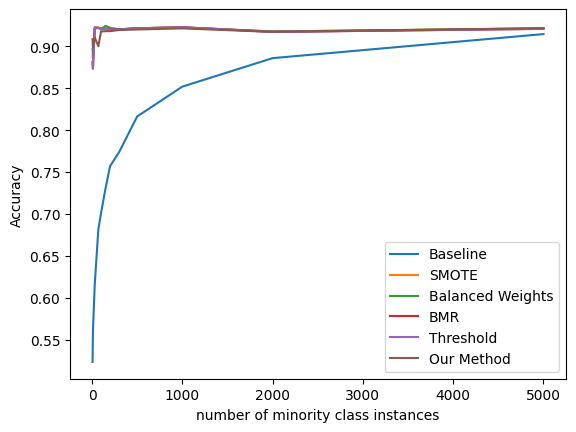

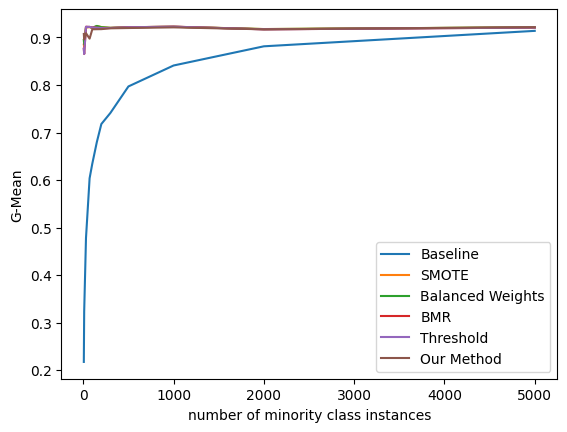

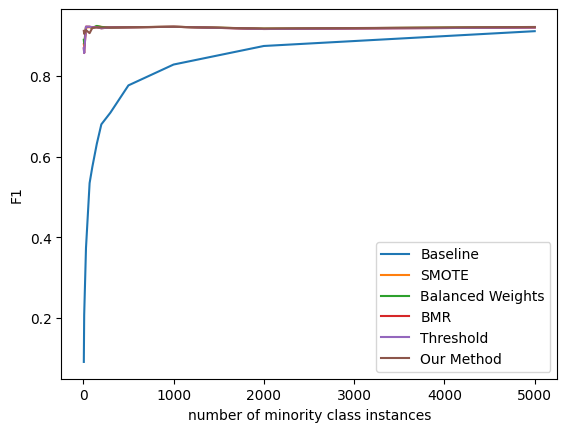

In [12]:
# setup data storage for plots
metrics = results[runs[0]][0].columns.to_list()
methods = results[runs[0]][0].index.to_list()
plot_info = {}
for metric in metrics:
    plot_info[metric] = {}
    for method in methods:
        plot_info[metric][method] = []

# extract data for plotting
for run in runs:
    dfs = results[run]
    df = pd.concat(dfs, axis=0)
    mean = {}
    std = {}
    index = df.index.unique().to_list()
    cols = df.columns.to_list()
    for method in index:
        mean[method] = df.loc[method].mean().to_list()
        std[method] = df.loc[method].std().to_list()
    for metric in cols:
        for method in mean.keys():
            plot_info[metric][method].append(mean[method][cols.index(metric)])
    
# plot 
for metric in metrics:
    for method in methods:
        plt.plot(runs, plot_info[metric][method], label=method)
    plt.legend()
    plt.ylabel(metric)
    plt.xlabel('number of minority class instances')
    plt.show()